In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from bs4 import BeautifulSoup
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

from model_utils import create_and_restore_model
from utils import load_image_into_numpy_array, plot_detections

%matplotlib inline

train_path = '/home/evan/Datasets/Hand Images/train/'
fine_tuned_ckpt_path = './fine_tuned_ckpts/ckpt'
num_classes = 1
pipeline_config = '/home/evan/Desktop/Tensorflow/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
load_ckpt_path = '/home/evan/Desktop/Tensorflow/models/research/object_detection/test_data/checkpoint/ckpt-0'

(orig_height, orig_width) = (544,960)
(new_height, new_width) = (640,640)
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
hand_class_id = 1
num_classes = 1

category_index = {hand_class_id: {'id': hand_class_id, 'name': 'hand'}}

# Load images and visualize

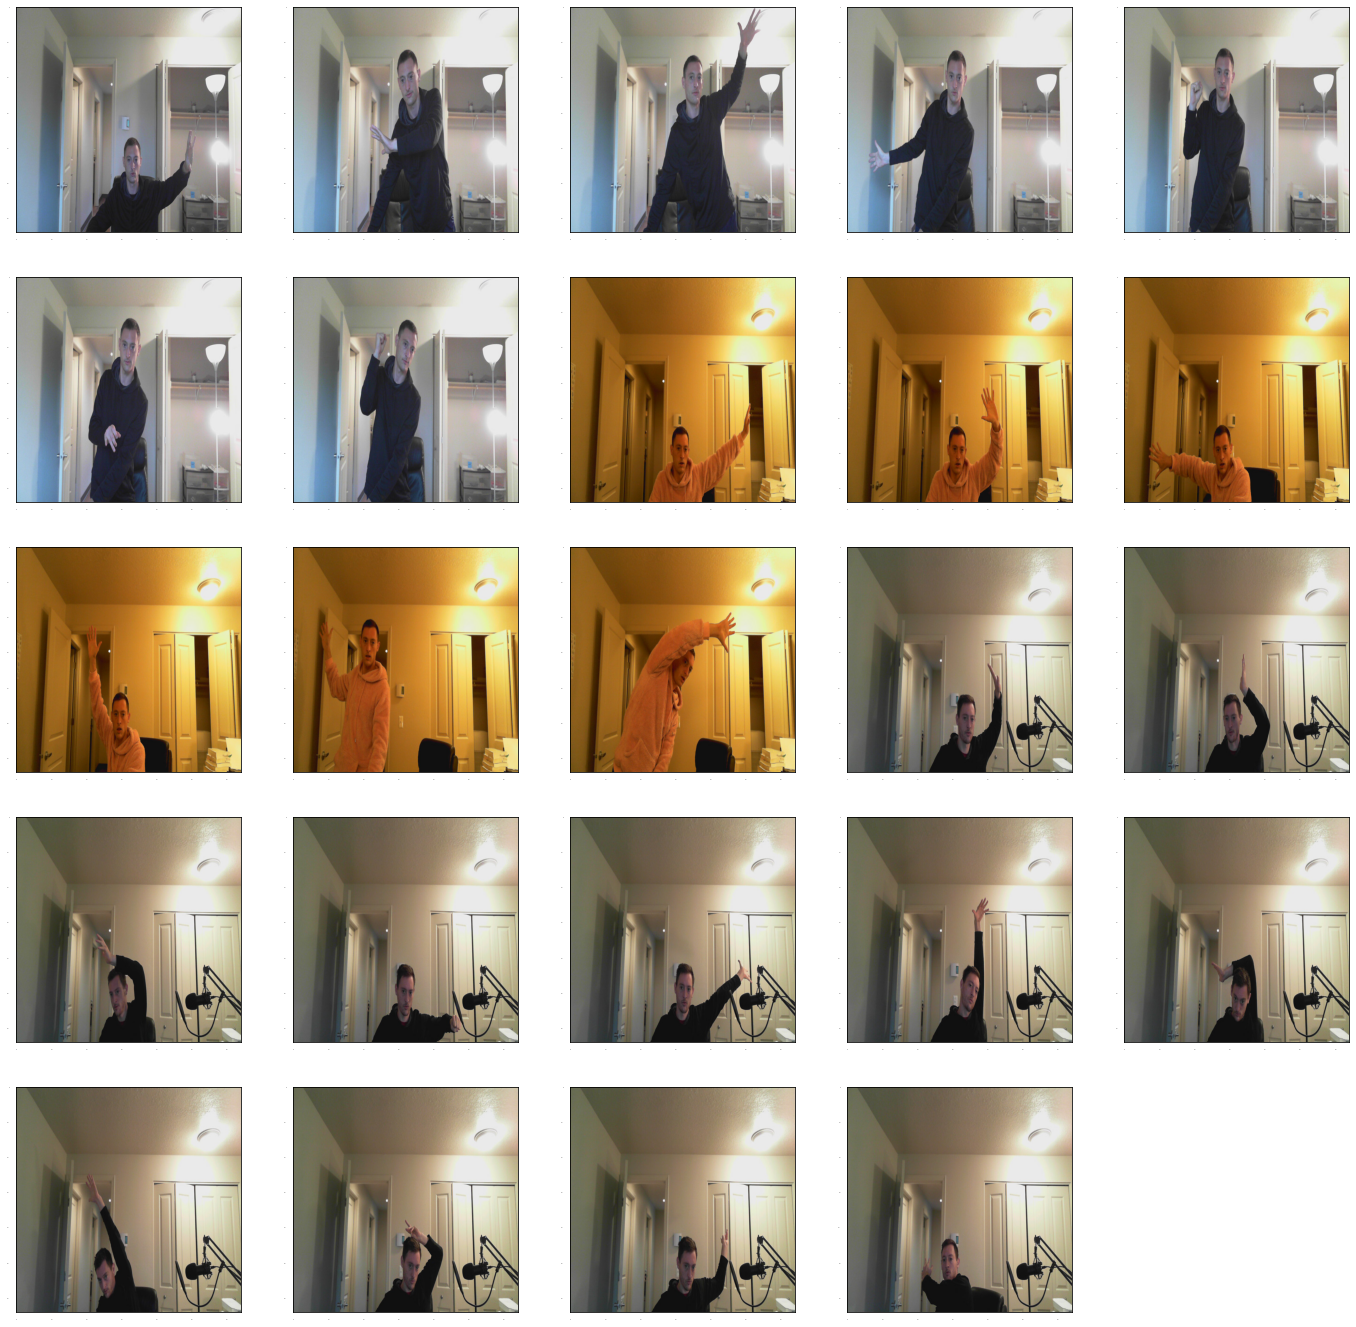

In [2]:
images_and_labels = os.listdir(train_path)
images_and_labels.sort()
labels = [x for x in images_and_labels if x.endswith('.xml')] 
images = [x for x in images_and_labels if x.endswith('.jpg')] 

train_images_np = []
for image in images:
    train_images_np.append(load_image_into_numpy_array(train_path+image, new_height, new_width, swap=False))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [len(train_images_np), len(train_images_np)]
for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(int(len(train_images_np)**.5)+1, int(len(train_images_np)**.5)+1, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Load annotations

In [3]:
labels_np = []
for filename in labels:
    infile = open(train_path+filename,"r")
    contents = infile.read()
    soup = BeautifulSoup(contents,'xml')
    xmin = soup.xmin.string
    ymin = soup.ymin.string
    xmax = soup.xmax.string
    ymax = soup.ymax.string
    # print(xmin,ymin,xmax,ymax)
    label = np.array([[ymin, xmin, ymax, xmax]], dtype=np.float32)/[[orig_height,orig_width,orig_height,orig_width]]
    # label = label * [[1,3/4,1,3/4]] #match label and picture aspect ratios to both 1:1
    # label = abs(label - [[0,1,0,1]]) #mirror x axis
    labels_np.append(label)
gt_boxes = labels_np

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [4]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


2021-11-04 15:08:05.131542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 15:08:05.135562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 15:08:05.135831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 15:08:05.136477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Visualize GT overlay


In [5]:
gt_boxes[0]

array([[0.54227941, 0.74583333, 0.73345588, 0.80416667]])

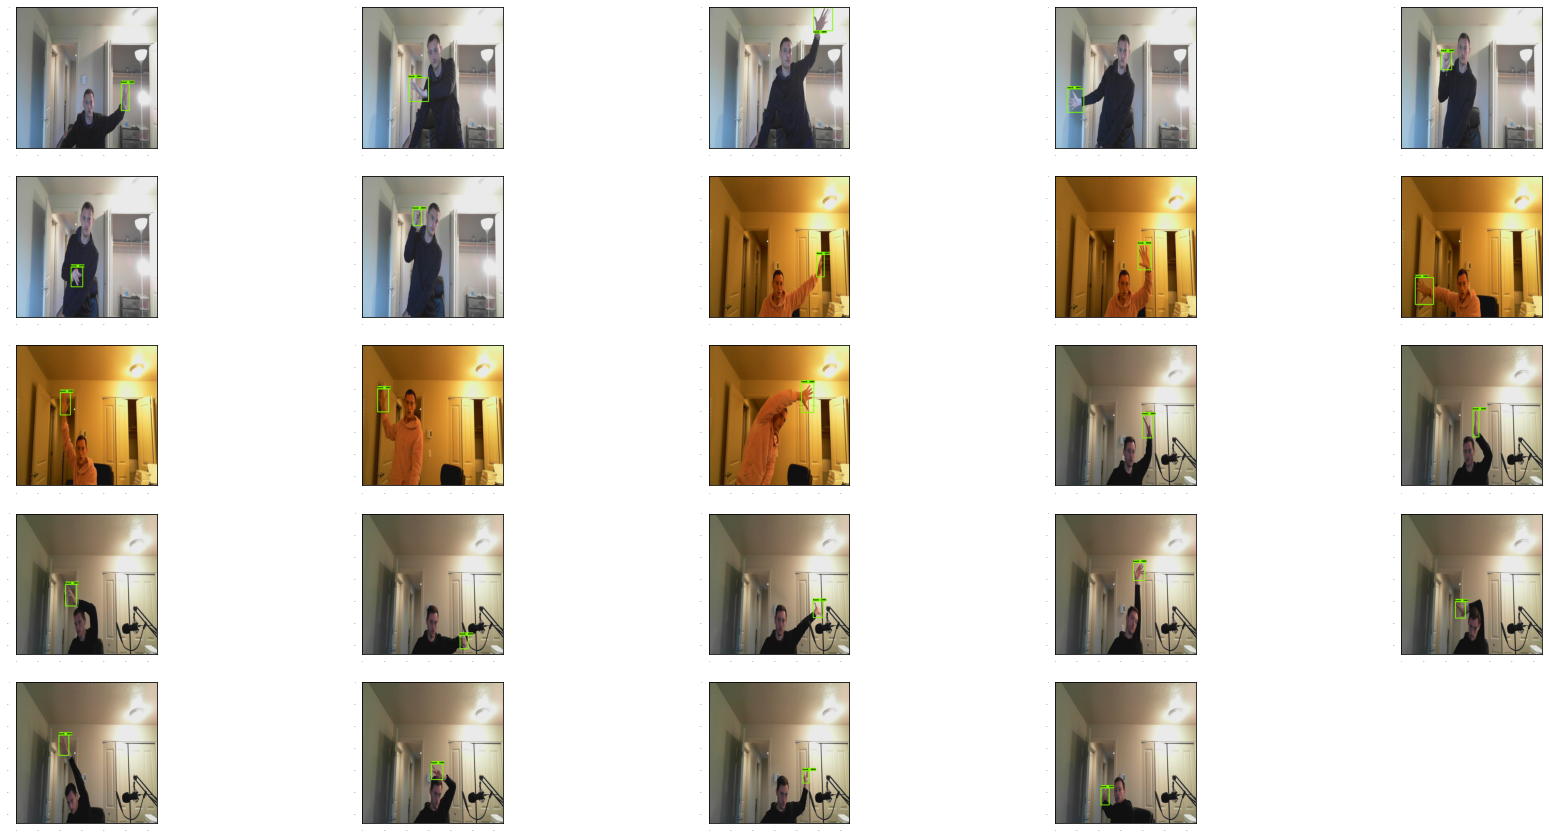

In [6]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(len(train_images_np)):
  plt.subplot(int(len(train_images_np)**.5)+1, int(len(train_images_np)**.5)+1, idx+1)
  image_np_with_annotations = \
  plot_detections(image_np =train_images_np[idx],
                  boxes = gt_boxes[idx],
                  classes = np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
                  scores = dummy_scores,
                  category_index = category_index,
                  figsize=(30, 15),
                  image_save_name=None,
                  min_score_thresh=0.1)
  plt.imshow(image_np_with_annotations)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [7]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
# !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [8]:
detection_model = \
create_and_restore_model(pipeline_config, 
                        load_ckpt_path, 
                        new_height, 
                        new_width, 
                        hand_class_id, 
                        num_classes)

Building model and restoring weights for fine-tuning...


2021-11-04 15:08:09.919323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


Weights restored!


# In-memory dataset GPU custom training loop

In [9]:
tf.keras.backend.set_learning_phase(True)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)#TODO not sure if need model = or no

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[new_height, new_width, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)


print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  with tf.device('/GPU:0'):
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2021-11-04 15:08:20.015922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


batch 0 of 1000, loss=1.4698443
batch 10 of 1000, loss=0.6153142
batch 20 of 1000, loss=0.68350196
batch 30 of 1000, loss=0.96666497
batch 40 of 1000, loss=0.50473154
batch 50 of 1000, loss=0.5301255
batch 60 of 1000, loss=0.30013782
batch 70 of 1000, loss=0.17840835
batch 80 of 1000, loss=0.20743316
batch 90 of 1000, loss=0.13829356
batch 100 of 1000, loss=0.105968624
batch 110 of 1000, loss=0.10851087
batch 120 of 1000, loss=0.118073225
batch 130 of 1000, loss=0.08148732
batch 140 of 1000, loss=0.055698138
batch 150 of 1000, loss=0.048443962
batch 160 of 1000, loss=0.06198576
batch 170 of 1000, loss=0.06473399
batch 180 of 1000, loss=0.06635416
batch 190 of 1000, loss=0.056105155
batch 200 of 1000, loss=0.04655535
batch 210 of 1000, loss=0.04220818
batch 220 of 1000, loss=0.053241786
batch 230 of 1000, loss=0.043252114
batch 240 of 1000, loss=0.042770144
batch 250 of 1000, loss=0.041604135
batch 260 of 1000, loss=0.047061305
batch 270 of 1000, loss=0.046386592
batch 280 of 1000, loss

In [10]:
#save final model (can ckpt multiple times by run inside loop)
ckpt.save(fine_tuned_ckpt_path)

'./fine_tuned_ckpts/ckpt-1'